# Vehicle Detection
---
## Goals
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.
---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import glob
from tqdm import *
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

%matplotlib inline

## Prepare data

In [3]:
vehicle_files = glob.glob('vehicles/**/*.png', recursive=True)
non_vehicle_files = glob.glob('non-vehicles/**/*.png', recursive=True)

vehicles = []
non_vehicles = []

for filename in tqdm(vehicle_files):
    vehicles.append(cv2.imread(filename))

for filename in tqdm(non_vehicle_files):
    non_vehicles.append(cv2.imread(filename))

100%|██████████| 8968/8968 [00:04<00:00, 1824.21it/s]


## Histogram of Orientated Gradients (HOG)

### Extracting features

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

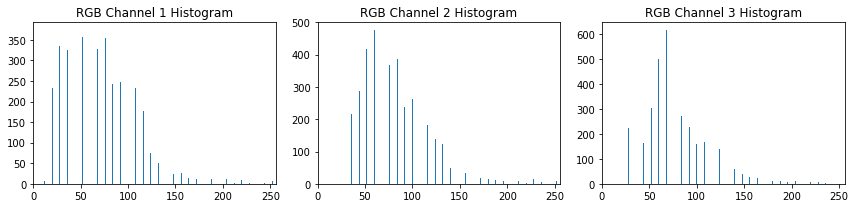

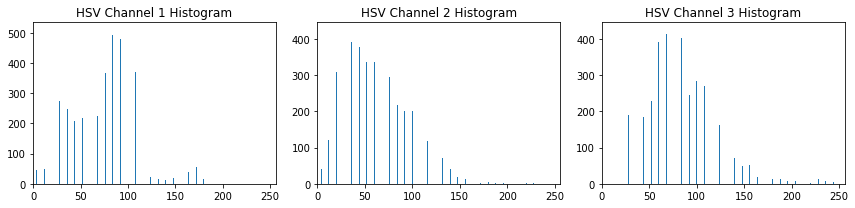

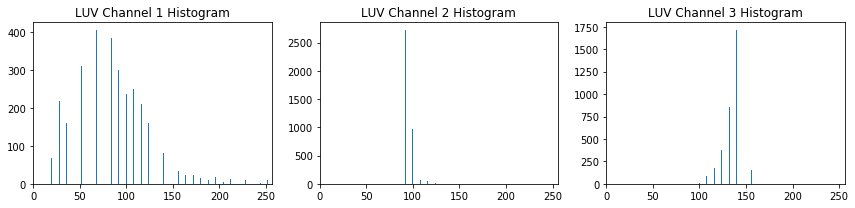

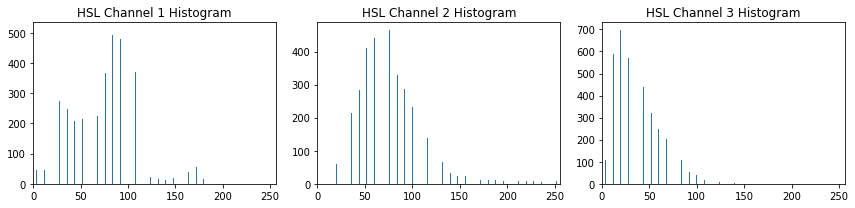

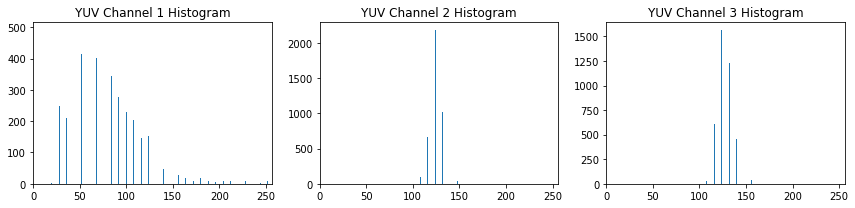

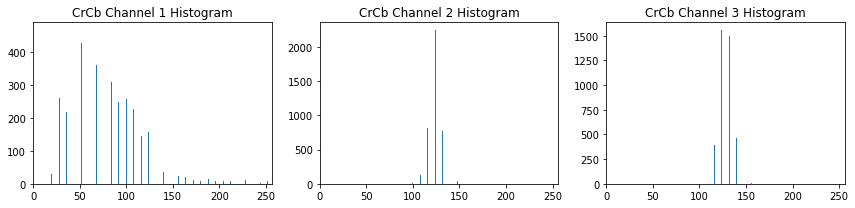

In [6]:
test_image_car = vehicles[200]
test_methods = [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HSV, cv2.COLOR_BGR2LUV, cv2.COLOR_BGR2HLS, cv2.COLOR_BGR2YUV, cv2.COLOR_BGR2YCrCb]
test_methods_names = ['RGB', 'HSV', 'LUV', 'HSL', 'YUV', 'CrCb']

for index, method in enumerate(test_methods):
    #plt.subplot(len(test_methods)*100+30+index)
    c1, c2, c3, bincen, feature_vec = color_hist(cv2.cvtColor(test_image_car, method))
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, c1[0])
    plt.xlim(0, 256)
    plt.title('{} Channel 1 Histogram'.format(test_methods_names[index]))
    plt.subplot(132)
    plt.bar(bincen, c2[0])
    plt.xlim(0, 256)
    plt.title('{} Channel 2 Histogram'.format(test_methods_names[index]))
    plt.subplot(133)
    plt.bar(bincen, c3[0])
    plt.xlim(0, 256)
    plt.title('{} Channel 3 Histogram'.format(test_methods_names[index]))
    fig.tight_layout()

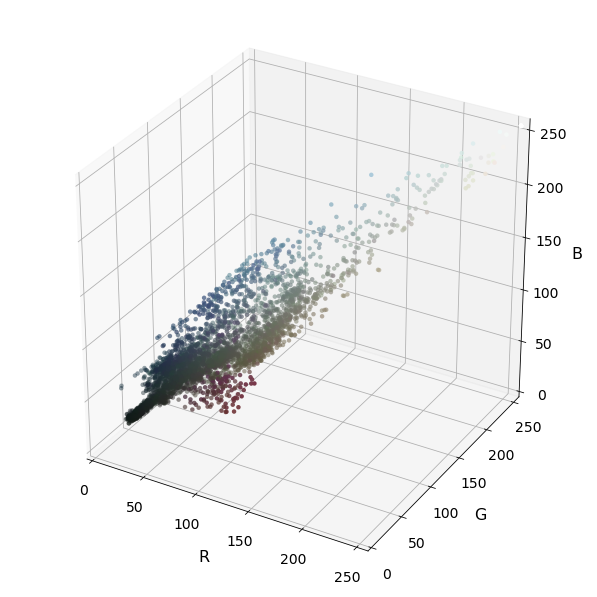

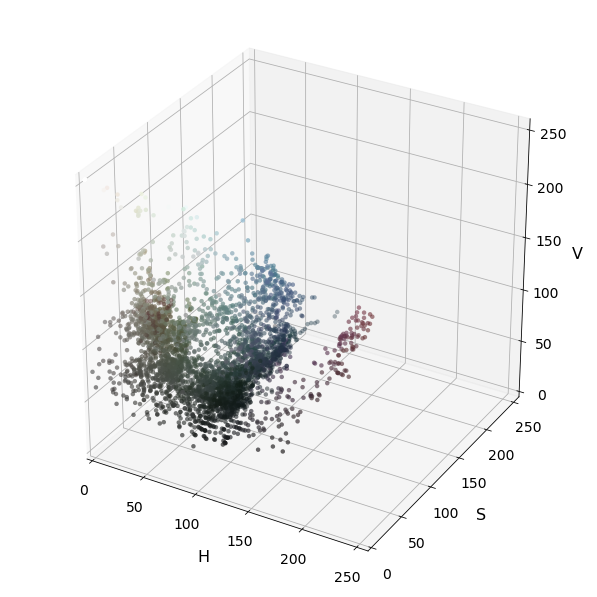

In [7]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Select a small fraction of pixels to plot by subsampling it
scale = max(test_image_car.shape[0], test_image_car.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(test_image_car, (np.int(test_image_car.shape[1] / scale), np.int(test_image_car.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

plot3d(img_small_RGB, img_small_rgb)
plt.show()
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

In [8]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

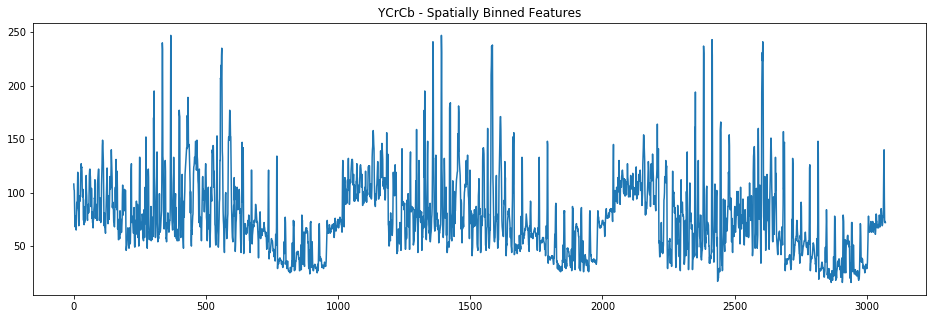

In [9]:
def test_bin(color_space):
    plt.figure(figsize=(16,5))
    feature_vec = bin_spatial(test_image_car, color_space=color_space)
    plt.plot(feature_vec)
    plt.title(color_space + ' - Spatially Binned Features')
    
interact(test_bin, color_space={'RGB':'RGB', 'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'});

In [10]:
def get_hog_features(image, cspace='RGB', orient=8, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0, vis=False, feat_vec=True):
    if cspace != 'RGB' and cspace != None:
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: 
        feature_image = np.copy(image)
        
    img = feature_image[:,:,hog_channel]
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=pix_per_cell, cells_per_block=cell_per_block, visualise=vis, transform_sqrt=False, feature_vector=feat_vec, normalise=None)
        return features

In [11]:
def get_hog(image, cspace='RGB', orient=8, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0, vis=False, feat_vec=True):
    return get_hog_features(image, cspace, orient, pix_per_cell, cell_per_block, hog_channel, vis, feat_vec)
        

In [12]:
def get_hog_interact(image, cspace, orient =8, npixpercells =8, cellsperblock = 1, vis=True, feat_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = get_hog_features(image, cspace, orient, (npixpercells,npixpercells), (cellsperblock,cellsperblock), vis, feat_vec)
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(hog_image, cmap = 'gray')
    else:      
        features = get_hog_features(image, cspace, orient, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), hog_channel, vis, feat_vec)

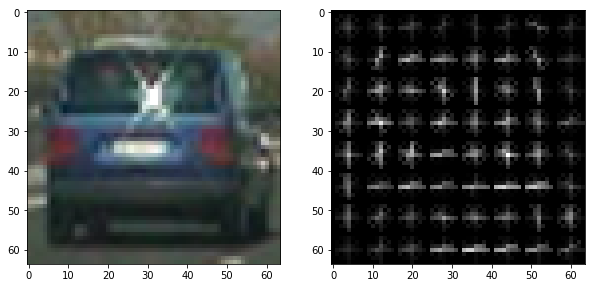

In [13]:
interact(get_hog_interact, image=fixed(test_image_car),cspace={'RGB':'RGB','HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb'},orient=(1,16), npixpercells =(1,16), cellsperblock =(1,8),hog_channel=(0,2), vis=fixed(True), feat_vec=fixed(True))

## Train the classifier

In [39]:
def extract_features(imgs, cspace='RGB', orient=8, 
                        pix_per_cell=8, cell_per_block=4, hog_channel=0, spatialsize=32, bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        spatial = bin_spatial(img, cspace, size=(spatialsize,spatialsize))
        hist = color_hist(img, bins)[4]
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(get_hog_features(img, cspace, 
                                    orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 
                                    channel, vis=False, feat_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(get_hog_features(img, cspace, 
                                    orient, (pix_per_cell, px_per_cell), (cell_per_block, cell_per_block), 
                                    hog_channel, vis=False, feat_vec=True))
        # Append the new feature vector to the features list
        features.append(np.hstack((spatial, hist, hog_features)))
        
    # Return list of feature vectors
    return features

In [79]:
colorspace = 'YCrCb'
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL'
spatial = 32
bins = 16

t=time.time()

car_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatialsize=spatial, bins=bins)

notcar_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatialsize=spatial, bins=bins)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

66.26 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 4656
10.51 Seconds to train SVC...


In [80]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Labels        ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9893
SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.]
Labels         [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.]
0.00255 Seconds to predict 15 labels with SVC


In [81]:
## Store trained classifier
pickle.dump( svc, open( "SVC.p", "wb" ) )
pickle.dump(X_scaler, open( "xscaler.p", "wb"))

In [82]:
## Load classifier
svc_trained = pickle.load( open( "SVC.p", "rb" ) )
xscaler = pickle.load( open( "xscaler.p", "rb" ) )

## Sliding windows

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    span_x = x_start_stop[1] - x_start_stop[0]
    span_y = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    pix_per_step_x = np.int(xy_window[0]*(1-xy_overlap[0]))
    pix_per_step_y = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((span_x-nx_buffer)/pix_per_step_x) 
    ny_windows = np.int((span_y-ny_buffer)/pix_per_step_y) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
            startx = xs*pix_per_step_x + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*pix_per_step_y + y_start_stop[0]
            endy = starty + xy_window[1]
        # Append window position to list
            window_list.append(((startx, starty),(endx, endy)))
    # Return the list of windows
    return window_list

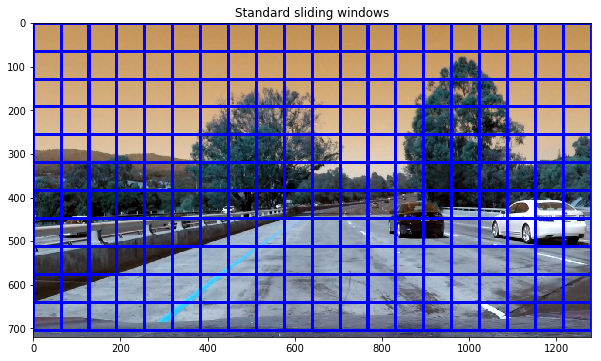

In [20]:
test_image = cv2.imread('./test_images/test1.jpg')
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)  
plt.figure(figsize=(10,10))
plt.title("Standard sliding windows")
plt.imshow(window_img)

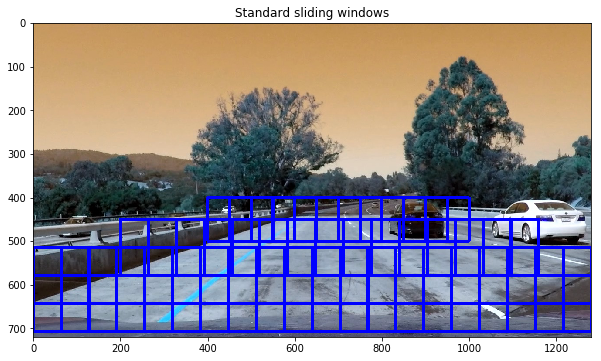

In [21]:
test_image = cv2.imread('./test_images/test1.jpg')
windows_1 = slide_window(test_image, x_start_stop=[400, 1000], y_start_stop=[400, 500], 
                    xy_window=(100, 100), xy_overlap=(0.5, 0.5))
windows_2 = slide_window(test_image, x_start_stop=[200, 1200], y_start_stop=[450, 578], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows_3 = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[514, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

windows = windows_1 + windows_2 + windows_3
window_img = draw_boxes(test_image, windows, color=(0, 0, 255), thick=6)  
plt.figure(figsize=(10,10))
plt.title("Standard sliding windows")
plt.imshow(window_img)

In [35]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_tosearch, None, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 0, vis=False, feat_vec=False)
    hog2 = get_hog_features(ctrans_tosearch, None, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 1,  vis=False, feat_vec=False)
    hog3 = get_hog_features(ctrans_tosearch, None, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 2,  vis=False, feat_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, 'YcrCb', size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)[4]
            # Scale features and make a prediction
            #test_features = X_scaler.transform(hog_features.reshape(1,-1))    
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                if vis:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    if vis:
        return boxes, draw_img
    return boxes

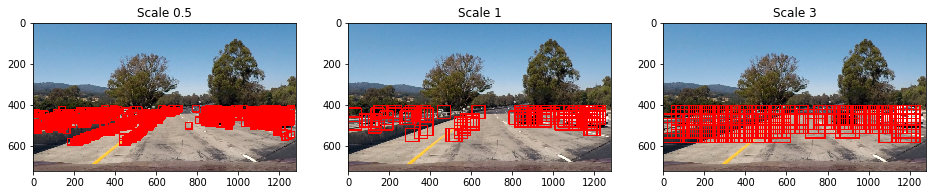

In [85]:
out_boxes, out_img = find_cars(test_image, 400, 600, 0.5, svc_trained, xscaler, 8, 7, 1, (32,32), 16)
out_boxes_1, out_img_1 = find_cars(test_image, 400, 600, 1, svc_trained, xscaler, 8, 7, 1, (32,32), 16)
out_boxes_2, out_img_2 = find_cars(test_image, 400, 600, 1.5, svc_trained, xscaler, 8, 7, 1, (32,32), 16)

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.title("Scale 0.5")
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.title("Scale 1")
plt.imshow(cv2.cvtColor(out_img_1, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.title("Scale 3")
plt.imshow(cv2.cvtColor(out_img_2, cv2.COLOR_BGR2RGB))

## Detect false positives

In [73]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

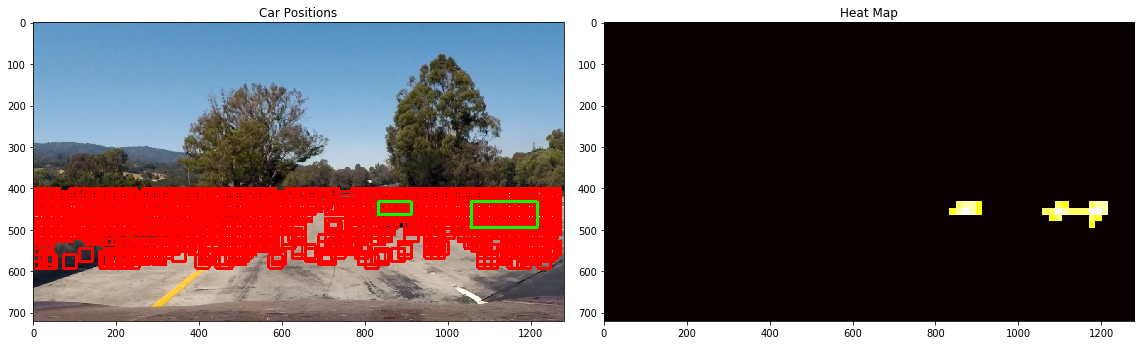

In [76]:
heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
heat = add_heat(heat, out_boxes_1)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,9)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img_2 = draw_labeled_bboxes(np.copy(out_img), labels)

fig = plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img_2, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline function

In [77]:
def pipeline(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    out_boxes = find_cars(image, 400, 600, 1, svc_trained, xscaler, 8, 8, 2, (32,32), 16, vis=False)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,out_boxes)
    heat = apply_threshold(heat,9)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return draw_labeled_bboxes(np.copy(image), labels)

In [78]:
output = 'out_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(40,44)
out_clip = clip1.fl_image(pipeline)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


 99%|█████████▉| 100/101 [00:58<00:00,  1.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 56.8 s, sys: 2.81 s, total: 59.6 s
Wall time: 59 s
